In [1]:
import pandas as pd
import numpy as np
import copy as cp
import sklearn.metrics as metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [3]:
from heatmap import heatmap, corrplot

## Load and Merge Data

In [4]:
onedrive_path = "C:/Users/cfowle/The Estée Lauder Companies Inc/TeamAnis - General/"

In [5]:
reviews = pd.read_csv(onedrive_path + "Data/Ratings and Reviews/reviews_demand_subcat.csv")
cc      = pd.read_csv(onedrive_path + "Data/Consumer Care/cc_product_month.csv")

C:\Users\cfowle\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
products = pd.read_csv(onedrive_path + "Data/Product/product_codes.csv")

C:\Users\cfowle\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,12,23,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(len(reviews))
reviews = reviews.drop(["item_description"], axis = 1).drop_duplicates()
print(len(reviews))

136630
122187


In [8]:
cc = cc.rename(columns = {"Date Month": "date", "P4": "itemid_4", "Brand Clean": "elc_brand"})
products = products.rename(columns = {"P4": "itemid_4", "brand": "elc_brand", "SubCategory":"sub_category"})
products = products[["elc_brand", "itemid_4", 'Major Category', 'Application', 'Category',
       'sub_category']].drop_duplicates(["elc_brand", "itemid_4"])

In [9]:
cc_product = cc.merge(products, how = "left", on = ["itemid_4", "elc_brand"])

In [10]:
cc_reviews_product = reviews.merge(cc_product, how = "left").fillna(0)
cc_reviews_product = cc_reviews_product.groupby(["elc_brand", "date", "sub_category"]).sum().reset_index()

## Feature Engineering
### Target Encoding

In [11]:
subcat_map = cc_reviews_product.groupby("sub_category")["demand"].mean().reset_index()
brand_map  = cc_reviews_product.groupby("elc_brand")["demand"].mean().reset_index()

cc_reviews_product["month"] = [x[-2:] for x in cc_reviews_product["date"].values]
cc_reviews_product["year"]  = [x[:4] for x in cc_reviews_product["date"].values]

month_map = cc_reviews_product.groupby("month")["demand"].mean().reset_index()
year_map  = cc_reviews_product.groupby("year")["demand"].mean().reset_index()

In [12]:
subcat_map = subcat_map.rename(columns = {"demand":"subcat_avg_demand"})
month_map  = month_map.rename(columns = {"demand":"month_avg_demand"})
year_map   = year_map.rename(columns = {"demand":"year_avg_demand"})
brand_map  = brand_map.rename(columns = {"demand":"brand_avg_demand"})

In [13]:
cc_reviews_product = cc_reviews_product.merge(subcat_map).merge(month_map).merge(year_map).merge(brand_map)
cc_reviews_product = cc_reviews_product.sort_values("date").reset_index(drop=True)

In [14]:
cc_reviews_product

,elc_brand,date,sub_category,major_category_id,avg_nb_statements,nb_reviews,rating,rating_1,rating_2,rating_3,...,Questions_Service_Miscellaneous,Questions_Website_Offer Codes,Questions_Website_Website functionality,Suggestions_Suggestion_Miscellaneous,month,year,subcat_avg_demand,month_avg_demand,year_avg_demand,brand_avg_demand
0,Aramis,2014-12,After Shave,530.0,0.000000,0,0.000000,0,0,0,...,0.0,0.0,0.0,0.0,12,2014,1906.184615,31816.180952,25517.980220,1659.630769
1,Smashbox,2014-12,All Eyelash Primer,510.0,0.000000,0,0.000000,0,0,0,...,0.0,0.0,0.0,0.0,12,2014,13837.451282,31816.180952,25517.980220,20558.440891
2,Smashbox,2014-12,All All Other Lips,1020.0,0.000000,0,0.000000,0,0,0,...,0.0,0.0,0.0,0.0,12,2014,1077.126923,31816.180952,25517.980220,20558.440891
3,Smashbox,2014-12,Stick Foundation,510.0,0.000000,0,0.000000,0,0,0,...,0.0,0.0,0.0,0.0,12,2014,11732.772308,31816.180952,25517.980220,20558.440891
4,Smashbox,2014-12,Pressed Face Powder,1020.0,0.000000,0,0.000000,0,0,0,...,0.0,0.0,0.0,0.0,12,2014,53907.084615,31816.180952,25517.980220,20558.440891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29570,Estée Lauder,2020-04,All Other Mascara,1530.0,2.500000,1,2.500000,0,0,0,...,0.0,0.0,0.0,0.0,04,2020,28223.265934,21587.236264,19931.730769,13684.797041
29571,Estée Lauder,2020-04,All Other Eyeshadows,510.0,0.000000,0,0.000000,0,0,0,...,0.0,0.0,0.0,0.0,04,2020,10997.128205,21587.236264,19931.730769,13684.797041
29572,Estée Lauder,2020-04,All Liquid Lip,1020.0,0.363636,1,0.454545,0,0,0,...,0.0,0.0,0.0,0.0,04,2020,32732.323077,21587.236264,19931.730769,13684.797041
29573,Estée Lauder,2020-04,Cream Foundation Com,510.0,1.305357,45,1.267857,1,3,1,...,0.0,0.0,0.0,0.0,04,2020,13218.715385,21587.236264,19931.730769,13684.797041


### Create dataset without customer data

In [15]:
non_customer_data = cc_reviews_product[["demand_F1", "demand", "demand_P2", "demand_P1",
                                   "subcat_avg_demand", "month_avg_demand", "year_avg_demand", "brand_avg_demand",
                                   "month", "year"]]

### Create Dataset with only Relative Measures

In [16]:
relative_data = cp.deepcopy(non_customer_data)
subcat = cc_reviews_product ##just here so I can copy some old code easily

In [17]:
relative_data["percent_1"] = subcat["rating_1"]/subcat["nb_reviews"]
relative_data["percent_2"] = subcat["rating_2"]/subcat["nb_reviews"]
relative_data["percent_3"] = subcat["rating_3"]/subcat["nb_reviews"]
relative_data["percent_4"] = subcat["rating_4"]/subcat["nb_reviews"]
relative_data["percent_5"] = subcat["rating_5"]/subcat["nb_reviews"]

In [18]:
relative_data["percent_negative"] = subcat['sentiment_negative']/subcat["nb_reviews"]
relative_data["percent_neutral"] = subcat['sentiment_neutral']/subcat["nb_reviews"]
relative_data["percent_positive"] = subcat['sentiment_positive']/subcat["nb_reviews"]

In [19]:
relative_data = relative_data.fillna(0)
relative_data

,demand_F1,demand,demand_P2,demand_P1,subcat_avg_demand,month_avg_demand,year_avg_demand,brand_avg_demand,month,year,percent_1,percent_2,percent_3,percent_4,percent_5,percent_negative,percent_neutral,percent_positive
0,195.0,0,0.0,0.0,1906.184615,31816.180952,25517.980220,1659.630769,12,2014,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0,0.0,0.0,13837.451282,31816.180952,25517.980220,20558.440891,12,2014,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,0,0.0,0.0,1077.126923,31816.180952,25517.980220,20558.440891,12,2014,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0,0.0,0.0,11732.772308,31816.180952,25517.980220,20558.440891,12,2014,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,155.0,204,780.0,189.0,53907.084615,31816.180952,25517.980220,20558.440891,12,2014,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29570,0.0,0,0.0,0.0,28223.265934,21587.236264,19931.730769,13684.797041,04,2020,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.200000,0.800000
29571,0.0,0,0.0,0.0,10997.128205,21587.236264,19931.730769,13684.797041,04,2020,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
29572,2431.0,906,6874.0,5131.0,32732.323077,21587.236264,19931.730769,13684.797041,04,2020,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.000000
29573,0.0,0,0.0,0.0,13218.715385,21587.236264,19931.730769,13684.797041,04,2020,0.022222,0.066667,0.022222,0.088889,0.8,0.088889,0.096296,0.814815


In [20]:
full_relative_data = cp.deepcopy(relative_data)

In [21]:
subcat["cc_tot"] = subcat['Complaints'] + subcat['Compliments'] + subcat['Questions'] + subcat['Suggestions']

In [22]:
cc_counts = cc.drop(['Product Code', 'itemid_4', 'elc_brand', "date"], axis = 1).columns

In [23]:
for col in cc_counts:
    full_relative_data["percent_" + col] = subcat[col]/subcat["cc_tot"]

In [24]:
full_relative_data = full_relative_data.fillna(0)

In [25]:
full_relative_data

,demand_F1,demand,demand_P2,demand_P1,subcat_avg_demand,month_avg_demand,year_avg_demand,brand_avg_demand,month,year,...,percent_Questions_Order_Returns,percent_Questions_Product_General,percent_Questions_Product_Packaging,percent_Questions_Product_Performance,percent_Questions_Product_Usage Related,percent_Questions_Service_Location,percent_Questions_Service_Miscellaneous,percent_Questions_Website_Offer Codes,percent_Questions_Website_Website functionality,percent_Suggestions_Suggestion_Miscellaneous
0,195.0,0,0.0,0.0,1906.184615,31816.180952,25517.980220,1659.630769,12,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0,0.0,0.0,13837.451282,31816.180952,25517.980220,20558.440891,12,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0,0.0,0.0,1077.126923,31816.180952,25517.980220,20558.440891,12,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0,0.0,0.0,11732.772308,31816.180952,25517.980220,20558.440891,12,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,155.0,204,780.0,189.0,53907.084615,31816.180952,25517.980220,20558.440891,12,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29570,0.0,0,0.0,0.0,28223.265934,21587.236264,19931.730769,13684.797041,04,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29571,0.0,0,0.0,0.0,10997.128205,21587.236264,19931.730769,13684.797041,04,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29572,2431.0,906,6874.0,5131.0,32732.323077,21587.236264,19931.730769,13684.797041,04,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29573,0.0,0,0.0,0.0,13218.715385,21587.236264,19931.730769,13684.797041,04,2020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build Model with Customer Data

In [26]:
X = relative_data.drop(["demand_F1"], axis = 1)
y = relative_data[["demand_F1"]]
X.columns

Index(['demand', 'demand_P2', 'demand_P1', 'subcat_avg_demand',
       'month_avg_demand', 'year_avg_demand', 'brand_avg_demand', 'month',
       'year', 'percent_1', 'percent_2', 'percent_3', 'percent_4', 'percent_5',
       'percent_negative', 'percent_neutral', 'percent_positive'],
      dtype='object')

In [27]:
X.to_csv(onedrive_path + "Output/2020_06_22_to_rama/input_data.csv")

Text(0, 0.5, 'cumulative explained variance')

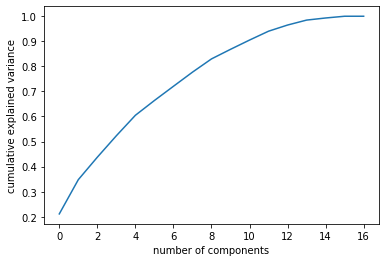

In [28]:
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [29]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [30]:
#principalDf.to_csv(onedrive_path + "Output/2020_06_22_to_rama/pca.csv")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, shuffle = False)

In [32]:
lm = LinearRegression()
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
metrics.r2_score(pred, y_test)

0.8277919882790479

In [33]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train.values.reshape(-1,1), X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 1.129e+04
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        05:57:34   Log-Likelihood:            -2.7415e+05
No. Observations:               22181   AIC:                         5.483e+05
Df Residuals:                   22170   BIC:                         5.484e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.09e+04    397.731     77.678      0.0

In [34]:
for i,x in enumerate(pca.components_):
    print("Feature " + str(i))
    top = x.argsort()[-5:][::-1]
    table = [list(relative_data.drop("demand_F1", axis = 1).columns[top]), x[top]]
    df = pd.DataFrame(np.transpose(table))
    print(df)

Feature 0
                  0                    1
0            demand  0.38783835681208517
1         demand_P1  0.38632155083472614
2         demand_P2  0.38524314256462394
3  percent_positive  0.36370986205911976
4         percent_5   0.3196450902801384
Feature 1
                   0                    1
0          demand_P1   0.3893871118129464
1             demand   0.3877544529057498
2          demand_P2   0.3847063177494749
3  subcat_avg_demand  0.15384147446268429
4              month  0.06289243505392107
Feature 2
                  0                    1
0              year   0.6418212226354334
1   year_avg_demand   0.5241643420077187
2         percent_1  0.13887576085771058
3  percent_negative  0.09060450800750504
4         demand_P2  0.04846545519234724
Feature 3
                  0                    1
0  month_avg_demand   0.5886720438521067
1             month   0.5877324290100793
2   year_avg_demand  0.33405292616359744
3         percent_1  0.25029907292304415
4  percent_

## Back out KPI

We see three features that strongly depend on R&R data. Let's take the three largest components of those features and multiply them by their regression coefficients to get a measure

In [35]:
def get_feature(pca_component, X, thresh):
    feature = []
    for i, x in enumerate(pca_component):
        if i >= thresh:
            if(len(feature) > 0):
                feature = feature + x*X[:,i]
            else:
                feature = x*X[:,i]
    return feature

In [42]:
feature_4= get_feature(pca.components_[4], X, 0.15)

In [43]:
metric = feature_4

In [44]:
X_train, X_test, y_train, y_test = train_test_split(metric.reshape(-1, 1), y, shuffle = False)

In [45]:
metric_lm = LinearRegression()
metric_lm.fit(X_train, y_train)
pred = metric_lm.predict(X_test)
metrics.r2_score(pred, y_test)

-49317.76383904037

In [46]:
pd.concat((pd.DataFrame(metric),y), axis = 1).corr()

,0,demand_F1
0,1.000000,0.025985
demand_F1,0.025985,1.000000


In [47]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train.values.reshape(-1,1), X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5928
Date:                Wed, 24 Jun 2020   Prob (F-statistic):              0.441
Time:                        05:58:40   Log-Likelihood:            -2.9420e+05
No. Observations:               22181   AIC:                         5.884e+05
Df Residuals:                   22179   BIC:                         5.884e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.025e+04    938.349     32.235      0.0

Signifcant, but no predictive power...what does that even mean?